# Topic Modeling using DEC(Deep Embedded Clustering)

### References

* Data: Drug Dataset (400EA)
* Preprocess: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
* DEC: https://github.com/Tony607/Keras_Deep_Clustering/blob/master/Keras-DEC.ipynb

In [49]:
from keras.datasets import mnist
import numpy as np

from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.engine.topology import Layer, InputSpec

from sklearn.cluster import KMeans
from keras.datasets import mnist
from sklearn import metrics

np.random.seed(10)

In [50]:
def autoencoderConv2D_1(input_shape=(28, 28, 1), filters=[32, 64, 128, 10]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [51]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [52]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [53]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

----

### Preprocessing

In [6]:
import pandas as pd

pd.set_option('display.max_colwidth', 999)
drug_data = pd.read_csv('./mallet_top_sen.tsv', sep='\t')

In [7]:
drug_data.head()

,Unnamed: 0,id,Topic_Num,Topic_Perc_Contribu,Topic_Keywords,Origin_Text,Text
0,0,44029,0.0,0.2935,"analysi, multivari, regress, variabl, model, predictor, cardiac, time, univari, heart",Hazard Ratio (and 95% Confidence Intervals) in Univariate and Multivariate Analysis of Predictors of Major Cardiac Events (Cardiac Death or Worsening of Heart Failure Leading to Heart Transplantation),"['hazard', 'ratio', 'confid', 'interv', 'univari', 'multivari', 'analysi', 'predictor', 'major', 'cardiac', 'event', 'cardiac', 'death', 'worsen', 'heart', 'failur', 'lead', 'heart', 'transplant']"
1,1,23344,0.0,0.2836,"analysi, multivari, regress, variabl, model, predictor, cardiac, time, univari, heart","Left Ventricular and Right Ventricular Ejection Fractions, Left Ventricular and Right Ventricular Mean Phases, Left-to-Right Mean Phase Difference (L-RMP) and Phase Standard Deviations for Both Ventricles in 30 Cases of Left Sided WPW legend","['leav', 'ventricular', 'right', 'ventricular', 'eject', 'fraction', 'leav', 'ventricular', 'right', 'ventricular', 'mean', 'phase', 'leav', 'right', 'mean', 'phase', 'differ', 'rmp', 'phase', 'standard', 'deviat', 'ventricl', 'case', 'leav', 'side', 'wpw']"
2,2,41163,0.0,0.2817,"analysi, multivari, regress, variabl, model, predictor, cardiac, time, univari, heart","Partial Regression Coefficients (All Subjects, n = 262) for Forward Stepwise Linear Regression for Dependent Variables Augmentation Pressure and Augmentation Index legend","['partial', 'regress', 'coeffici', 'subject', 'forward', 'stepwis', 'linear', 'regress', 'depend', 'variabl', 'augment', 'pressur', 'augment', 'index']"
3,3,23343,0.0,0.2797,"analysi, multivari, regress, variabl, model, predictor, cardiac, time, univari, heart","Left Ventricular (LVEF) and Right Ventricular (RVEF) Ejection Fractions, Left Ventricular (LVMP) and Right Ventricular (RVMP) Mean Phases, Left-to-Right Mean Phase Difference (L-RMP) and Phase Standard Deviations (LVPSD and RVPSD) for Both Ventricles in 14 Cases of Right Sided WPW legend","['leav', 'ventricular', 'lvef', 'right', 'ventricular', 'rvef', 'eject', 'fraction', 'leav', 'ventricular', 'lvmp', 'right', 'ventricular', 'rvmp', 'mean', 'phase', 'leav', 'right', 'mean', 'phase', 'differ', 'rmp', 'phase', 'standard', 'deviat', 'lvpsd', 'rvpsd', 'ventricl', 'case', 'right', 'side', 'wpw']"
4,4,24968,0.0,0.2782,"analysi, multivari, regress, variabl, model, predictor, cardiac, time, univari, heart",Predictors of Mortality by Multivariable Analysis: Variables Are Shown in the Order They Entered a Stepwise Cox Regression Model,"['predictor', 'mortal', 'multivari', 'analysi', 'variabl', 'show', 'order', 'enter', 'stepwis', 'cox', 'regress', 'model']"


In [54]:
data_text = drug_data[['Origin_Text']]
data_text['index'] = drug_data[['Unnamed: 0']]
documents = data_text
documents.head()

/Users/gracelee/.pyenv/versions/for_jupyter/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Origin_Text,index
0,Hazard Ratio (and 95% Confidence Intervals) in Univariate and Multivariate Analysis of Predictors of Major Cardiac Events (Cardiac Death or Worsening of Heart Failure Leading to Heart Transplantation),0
1,"Left Ventricular and Right Ventricular Ejection Fractions, Left Ventricular and Right Ventricular Mean Phases, Left-to-Right Mean Phase Difference (L-RMP) and Phase Standard Deviations for Both Ventricles in 30 Cases of Left Sided WPW legend",1
2,"Partial Regression Coefficients (All Subjects, n = 262) for Forward Stepwise Linear Regression for Dependent Variables Augmentation Pressure and Augmentation Index legend",2
3,"Left Ventricular (LVEF) and Right Ventricular (RVEF) Ejection Fractions, Left Ventricular (LVMP) and Right Ventricular (RVMP) Mean Phases, Left-to-Right Mean Phase Difference (L-RMP) and Phase Standard Deviations (LVPSD and RVPSD) for Both Ventricles in 14 Cases of Right Sided WPW legend",3
4,Predictors of Mortality by Multivariable Analysis: Variables Are Shown in the Order They Entered a Stepwise Cox Regression Model,4


In [55]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import numpy as np
np.random.seed(2018)

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gracelee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [56]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [57]:
%time processed_docs = documents['Origin_Text'].map(preprocess)
processed_docs[:10]

CPU times: user 605 ms, sys: 2.23 ms, total: 607 ms
Wall time: 609 ms


0                                                                                        [hazard, ratio, confid, interv, univari, multivari, analysi, predictor, major, cardiac, event, cardiac, death, worsen, heart, failur, lead, heart, transplant]
1                                           [leav, ventricular, right, ventricular, eject, fraction, leav, ventricular, right, ventricular, mean, phase, leav, right, mean, phase, differ, phase, standard, deviat, ventricl, case, leav, side, legend]
2                                                                                                                   [partial, regress, coeffici, subject, forward, stepwis, linear, regress, depend, variabl, augment, pressur, augment, index, legend]
3    [leav, ventricular, lvef, right, ventricular, rvef, eject, fraction, leav, ventricular, lvmp, right, ventricular, rvmp, mean, phase, leav, right, mean, phase, differ, phase, standard, deviat, lvpsd, rvpsd, ventricl, case, right, side, legend]
4       

In [58]:
### TSNE모델에는 transform 메소드가 없고 fit_transform만 있음
# library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

np.random.seed(2018)

In [59]:
type(documents['Origin_Text'].values.tolist())

list

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
%time vect.fit([' '.join(d) for d in processed_docs])
%time tsne_data = vect.transform([' '.join(d) for d in processed_docs]).toarray()
%time tsne_result = TSNE(learning_rate=300, init='pca').fit_transform(np.array(tsne_data))

CPU times: user 25.7 ms, sys: 1.46 ms, total: 27.2 ms
Wall time: 26.3 ms
CPU times: user 23.5 ms, sys: 492 µs, total: 24 ms
Wall time: 23.7 ms
CPU times: user 16.5 s, sys: 1.22 s, total: 17.7 s
Wall time: 17.6 s


In [61]:
tsne_data[:10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [62]:
tsne_data.shape

(400, 1240)

----

## Fuuly Connected DEC

### Load Dataset

In [17]:
from keras.initializers import VarianceScaling
from keras.optimizers import SGD

In [18]:
max_count = max([np.max(tsne_data[i]) for i in tsne_data]) * 1.
x = np.divide(tsne_data, max_count)
n_clusters = 8

### Create Fully Connection Model

In [19]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256

In [20]:
autoencoder, encoder = autoencoder(dims, init=init)
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1240)         0                                            
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 500)          620500      input[0][0]                      
__________________________________________________________________________________________________
encoder_1 (Dense)               (None, 500)          250500      encoder_0[0][0]                  
__________________________________________________________________________________________________
encoder_2 (Dense)               (None, 2000)         1002000     encoder_1[0][0]                  
__________________________________________________________________________________________________
encoder_3 

### Train Model

In [27]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
%time autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights('./drug_ae_weights.h5')

Epoch 1/300
400/400 [==============================] - 1s 3ms/step - loss: 9.8193e-04
Epoch 2/300
400/400 [==============================] - 1s 2ms/step - loss: 9.8146e-04
Epoch 3/300
400/400 [==============================] - 1s 2ms/step - loss: 9.8063e-04
Epoch 4/300
400/400 [==============================] - 1s 1ms/step - loss: 9.7948e-04
Epoch 5/300
400/400 [==============================] - 1s 2ms/step - loss: 9.7808e-04
Epoch 6/300
400/400 [==============================] - 1s 2ms/step - loss: 9.7658e-04
Epoch 7/300
400/400 [==============================] - 1s 1ms/step - loss: 9.7493e-04
Epoch 8/300
400/400 [==============================] - 1s 1ms/step - loss: 9.7324e-04
Epoch 9/300
400/400 [==============================] - 1s 2ms/step - loss: 9.7153e-04
Epoch 10/300
400/400 [==============================] - 1s 1ms/step - loss: 9.6990e-04
Epoch 11/300
400/400 [==============================] - 1s 1ms/step - loss: 9.6828e-04
Epoch 12/300
400/400 [==============================

#### Train Time in Colab w/ GPU
* CPU times: user 2min 9s, sys: 4.39 s, total: 2min 14s
* Wall time: 1min 13s

In [28]:
autoencoder.load_weights('./drug_ae_weights.h5')

### Initialize cluster centers using k-means

In [29]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

### Deep Clustering Train

In [30]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

tol = 0.001 # tolerance threshold to stop training

In [31]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [32]:
y = None

In [33]:
# for ite in range(int(maxiter)):
#     if ite % update_interval == 0:
#         q, _  = model.predict(x, verbose=0)
#         p = target_distribution(q)  # update the auxiliary target distribution p

#         # evaluate the clustering performance
#         y_pred = q.argmax(1)
#         if y is not None:
#             acc = np.round(metrics.accuracy_score(y, y_pred), 5)
#             nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
#             ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
#             loss = np.round(loss, 5)
#             print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

#         # check stop criterion
#         delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
#         y_pred_last = np.copy(y_pred)
#         if ite > 0 and delta_label < tol:
#             print('delta_label ', delta_label, '< tol ', tol)
#             print('Reached tolerance threshold. Stopping training.')
#             break
#     idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
#     loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
#     index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

# model.save_weights('./b_DEC_model_final.h5')

In [34]:
model.load_weights('./drug_DEC_model_final.h5')

### Evaluation

#### Compare with LDA Results

In [40]:
lda_result = pd.read_csv('./lda.tsv', sep='\t')
y_lda = lda_result.topic.values

In [41]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.accuracy_score(y_lda, y_pred), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(y_lda, y_pred), 5)
    ari = np.round(metrics.adjusted_rand_score(y_lda, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Text(0.5, 54.5, 'Clustering label')

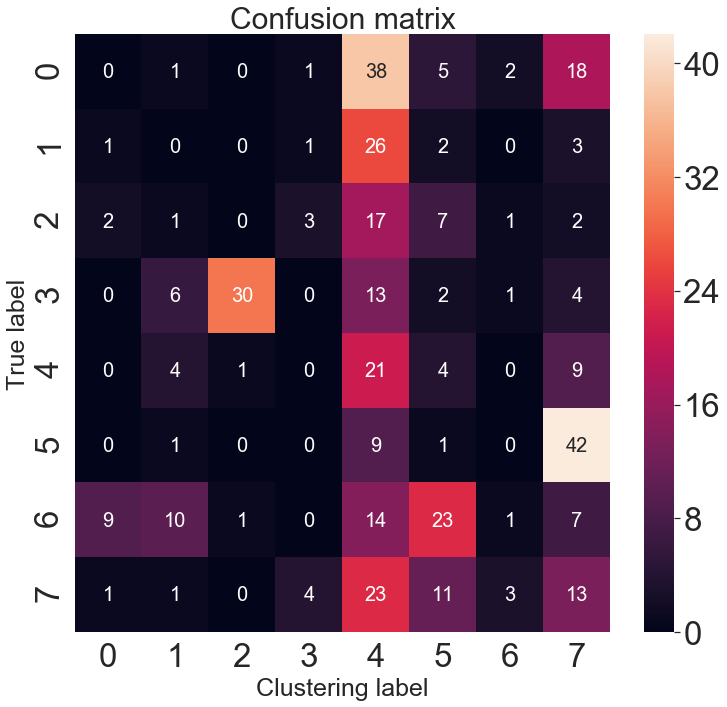

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = metrics.confusion_matrix(y_lda, y_pred)

plt.figure(figsize=(12, 11))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)

#### Compare with K-Means Results

In [44]:
km_result = pd.read_csv('./km.tsv', sep='\t')
y_km = km_result.topic.values

In [45]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.accuracy_score(y_km, y_pred), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(y_km, y_pred), 5)
    ari = np.round(metrics.adjusted_rand_score(y_km, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Text(0.5, 54.5, 'Clustering label')

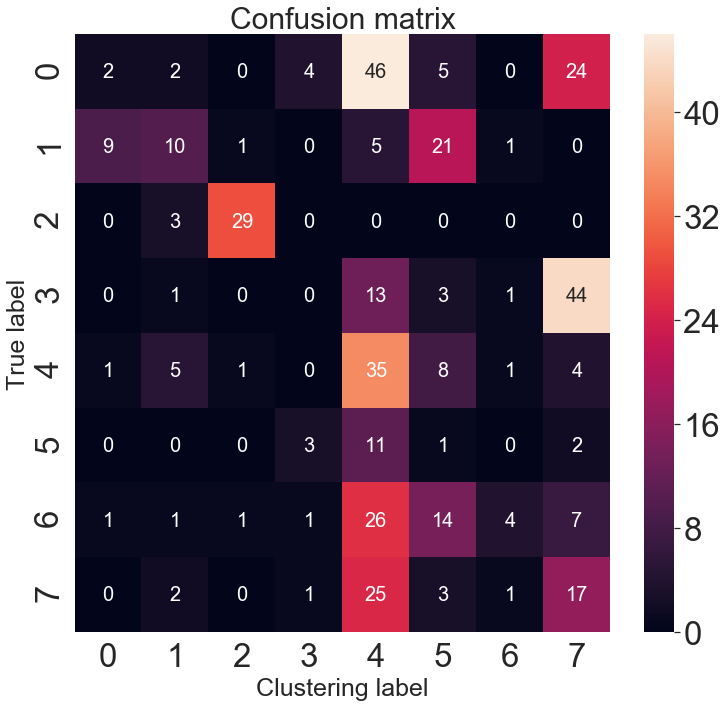

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = metrics.confusion_matrix(y_km, y_pred)

plt.figure(figsize=(12, 11))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)

----

### Visualization

#### 1. HBAR Chart

In [73]:
import numpy as np

doc_lengths = np.asarray(tsne_data.sum(axis=1)).reshape(-1)
term_frequency = np.asarray(tsne_data.sum(axis=0)).reshape(-1)

In [75]:
docwords = list(processed_docs.apply(lambda x: len(x)).values)
vocab = list(set(np.sum(processed_docs.values)))

In [84]:
from kmeans_to_pyLDAvis import kmeans_to_prepared_data

vis_data = kmeans_to_prepared_data(
    tsne_data,
    vocab,
    np.zeros((8, 1240)),
    y_pred,
    n_printed_words = 10,
    radius = 5
)

/workspace/_private_kyle/Topic_Modeling/kmeans_to_pyLDAvis/proportion.py:104: RuntimeWarning: invalid value encountered in true_divide
  term_proportion = weighted_centers / weighted_center_sum
/workspace/_private_kyle/Topic_Modeling/kmeans_to_pyLDAvis/proportion.py:99: RuntimeWarning: invalid value encountered in true_divide
  l1_normalize = lambda x:x/x.sum()
/workspace/_private_kyle/Topic_Modeling/kmeans_to_pyLDAvis/proportion.py:136: RuntimeWarning: invalid value encountered in greater
  indices = np.where(p_prop > 0)[0]
/workspace/_private_kyle/Topic_Modeling/kmeans_to_pyLDAvis/proportion.py:71: RuntimeWarning: invalid value encountered in true_divide
  term_proportion = weighted_centers / weighted_centers.sum(axis=0)


In [86]:
vis_data.topic_info.head()

,term,Category,Freq,Term,Total,loglift,logprob
0,781,Default,0.99,preval,127,25.000000,25.000000
1,381,Default,0.99,random,82,19.685039,19.685039
2,1148,Default,0.99,dysfunct,71,18.385827,18.385827
3,26,Default,0.99,compris,70,18.267717,18.267717
4,1233,Default,0.99,intracoronari,62,17.322835,17.322835


In [87]:
import json

hbar_json = {}
hbar_json['labels'] = vis_data.topic_info.Category.unique().tolist()
hbar_json['max_width'] = vis_data.topic_info[vis_data.topic_info.Category != 'Default'][['Total']].max()[0]
for l in vis_data.topic_info.Category.unique().tolist():
    tmp_df = vis_data.topic_info[vis_data.topic_info.Category == l].sort_values(['Category', 'Freq'], ascending=[True, False]).groupby('Category').head()
    sub_json = {}

    hbar_json[l] = list(tmp_df[['Term', 'Freq', 'Total']].sort_values('Freq', ascending=False).reset_index().to_dict('index').values())
    
f = open('./dec/hbar_data.json', 'w')
f.write(json.dumps(hbar_json, indent=4))
f.close()

#### 2. Scatter Chart

In [63]:
doc_result = documents[['index', 'Origin_Text']]
doc_result.columns = ['id', 'document']
doc_result['topic'] = y_pred
doc_result = pd.merge(doc_result, pd.DataFrame(tsne_result, columns=['plot_x', 'plot_y']), left_index=True, right_index=True)

doc_result.head()

/Users/gracelee/.pyenv/versions/for_jupyter/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,document,topic,plot_x,plot_y
0,0,Hazard Ratio (and 95% Confidence Intervals) in Univariate and Multivariate Analysis of Predictors of Major Cardiac Events (Cardiac Death or Worsening of Heart Failure Leading to Heart Transplantation),4,9.664474,8.992035
1,1,"Left Ventricular and Right Ventricular Ejection Fractions, Left Ventricular and Right Ventricular Mean Phases, Left-to-Right Mean Phase Difference (L-RMP) and Phase Standard Deviations for Both Ventricles in 30 Cases of Left Sided WPW legend",7,23.601093,-15.201797
2,2,"Partial Regression Coefficients (All Subjects, n = 262) for Forward Stepwise Linear Regression for Dependent Variables Augmentation Pressure and Augmentation Index legend",7,11.646137,0.977639
3,3,"Left Ventricular (LVEF) and Right Ventricular (RVEF) Ejection Fractions, Left Ventricular (LVMP) and Right Ventricular (RVMP) Mean Phases, Left-to-Right Mean Phase Difference (L-RMP) and Phase Standard Deviations (LVPSD and RVPSD) for Both Ventricles in 14 Cases of Right Sided WPW legend",7,23.601820,-15.202716
4,4,Predictors of Mortality by Multivariable Analysis: Variables Are Shown in the Order They Entered a Stepwise Cox Regression Model,7,8.242556,3.281180


In [66]:
scatter_json = list(doc_result[['id', 'plot_x', 'plot_y', 'topic']].to_dict('index').values())

f = open('./dec/scatter_data.json', 'w')
f.write(json.dumps(scatter_json, indent=4))
f.close()

#### 3. Table

In [67]:
doc_result.to_csv('dec.tsv', sep='\t', index_label=False)